# Defining the model

In [1]:
# ! pip install --upgrade albumentations

In [1]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

/home/bindas/anaconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:115.)
  return torch._C._cuda_getDeviceCount() > 0


device(type='cpu')

In [3]:
!nvidia-smi

Thu Sep 30 14:21:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 470.63.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:0A:00.0  On |                  N/A |
| 50%   34C    P0    88W / 320W |   2007MiB / 10014MiB |     26%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

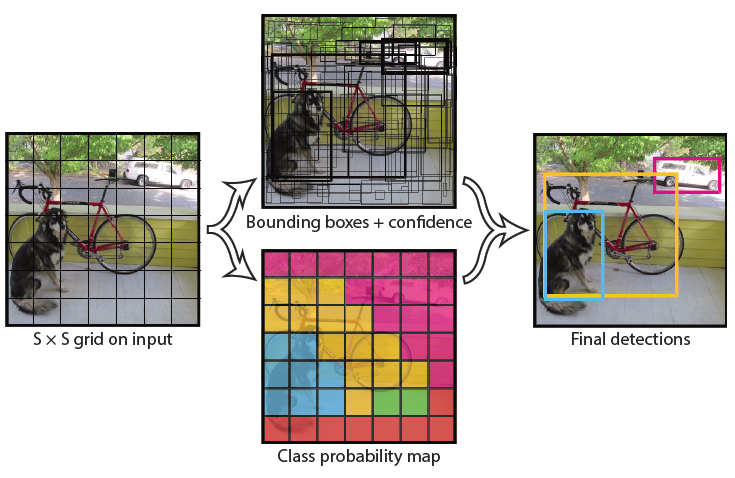

In [4]:
import dataset
import utils

from torch.optim import SGD

## Architecture
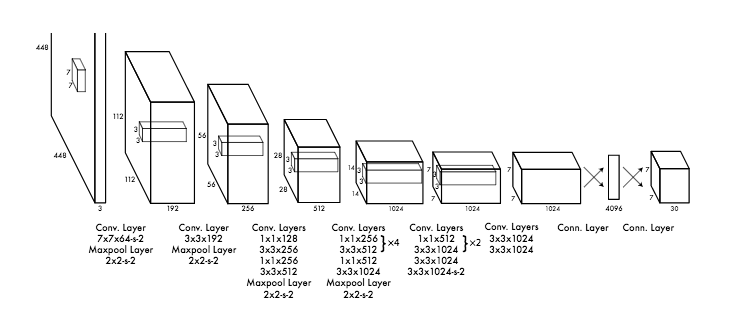

In [5]:
import torch.nn as nn
import torch.nn.functional as F

# constants
# size of grid
S = 7
# number of bounding boxes per grid cell
B = 2
# no classes
C = 20


class darknet(nn.Module):
    def __init__(self, pretrain=False):
        super(darknet, self).__init__()
        
        self.convolutional_layers = self._make_convolutional_layers()
        
        self.fc_layers = nn.Sequential(
            nn.Linear(1024 * S * S, 4096),
            nn.LeakyReLU(0.1),
            nn.Linear(4096, S * S * (B * 5 + C)),
        )

    def forward(self, x):
        # for loop with print size for debugging
        for layer in self.convolutional_layers:
            x = layer(x)
            # print(x.size())
            
#         x = self.convolutional_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        x = x.view(x.size(0), S, S,  B * 5 + C)
        return x
    
    def _make_convolutional_layers(self, batch_norm=True):
        convolutional_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2, stride=2),
            
            nn.Conv2d(64, 192, 3, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2, stride=2),
            
#             [1, 192, 56, 56]
            
            nn.Conv2d(192, 128, 1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(256, 256, 1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2, stride=2),
            
#             [1, 256, 28, 28]
            
            nn.Conv2d(512, 256, 1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(512, 256, 1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(512, 256, 1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(512, 256, 1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(512, 512, 1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(512, 1024, 3, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2, stride=2),
            
#             [1, 1024, 14, 14]
            
            nn.Conv2d(1024, 512, 1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(512, 1024, 3, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(1024, 512, 1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(512, 1024, 3, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(1024, 1024, 3, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(1024, 1024, 3, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            
#             [1, 1024, 7, 7]
            
            nn.Conv2d(1024, 1024, 3, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(1024, 1024, 3, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
        )
        return convolutional_layers


net = darknet()
print(net)

darknet(
  (convolutional_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.1, inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 128, kernel_size=(1, 1), stride=(1, 1))
    (7): LeakyReLU(negative_slope=0.1, inplace=True)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): LeakyReLU(negative_slope=0.1, inplace=True)
    (10): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (11): LeakyReLU(negative_slope=0.1, inplace=True)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): LeakyReLU(negative_slope=0.1, inplace=True)
    (14): MaxPool2d(kernel_size=2, st

In [6]:
def test(net):
    x = torch.randn(2, 3, 448, 448)
    return net(x)

In [7]:
test(net).size()

/home/bindas/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([2, 7, 7, 30])

## Training

To avoid overfitting:
- dropout is used with rate 0.5 after the first connected layer
- extensive data augmentation is used - random scaling and translations of up to 20% of the original image size
- also randomly adjust the exposure and saturation of the image by up to factor of 1.5 in the HSV color space

### Constants

In [8]:
# from the paper
MOMENTUM = 0.9
EPOCHS = 1
DECAY = 0.0005
# model is trained with 135 epochs
# first 5 epochs from 0.001 to 0.1
# 75 epochs 0.01 epochs
# 30 epochs 0.001
# 30 epochs 0.0001
LEARNING_RATE = 0.01
LAMBDA_NOOBJ = 0.5
LAMBDA_COORD = 5
SMOOTH = 1e-6

Using downloaded and verified file: ./data/VOCtrainval_06-Nov-2007.tar
Extracting ./data/VOCtrainval_06-Nov-2007.tar to ./data
Using downloaded and verified file: ./data/VOCtest_06-Nov-2007.tar
Extracting ./data/VOCtest_06-Nov-2007.tar to ./data
Feature batch shape for training: torch.Size([4, 3, 448, 448])
Objects batch shape for training: 4
Labels matrix batch shape for training: torch.Size([4, 7, 7, 25])
Sample batch for training dataloader is presented below:


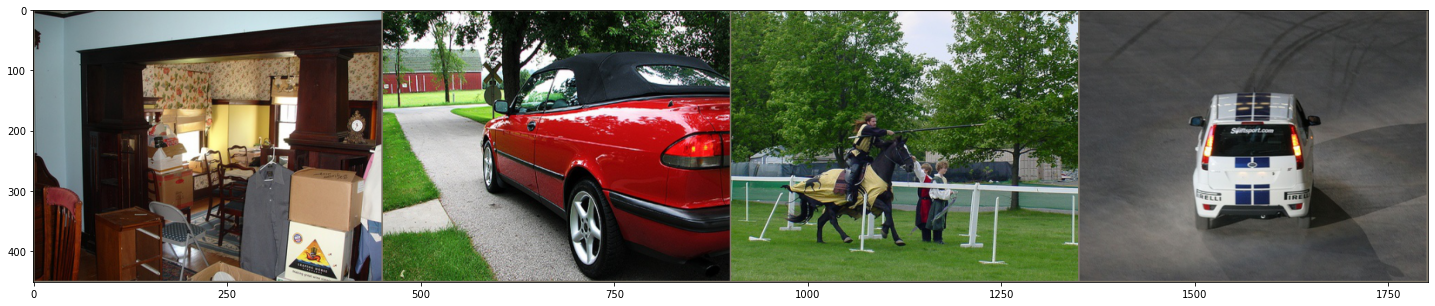

In [9]:
train_dl, test_dl = dataset.prepare_data()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


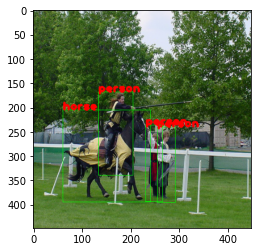

In [12]:
image, labels, _ = iter(train_dl).next()
utils.show_image_with_classes(image[2], labels[2])

### IOU

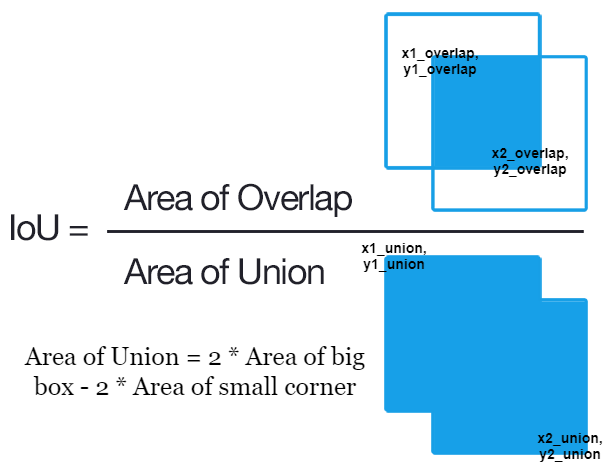

In [13]:
### TODO -> CHANGE TO WORK WITH TENSORS

def IOU(box_predicted, box_target):
  # I assume that the box is a list of 4 coordinates xmin, ymin, xmax, ymax
  # OVERLAP
    x1_overlap = max(box_predicted[0], box_target[0])
    y1_overlap = max(box_predicted[1], box_target[1])
    x2_overlap = min(box_predicted[2], box_target[2])
    y2_overlap = min(box_predicted[3], box_target[3])

    x1_union = min(box_predicted[0], box_target[0])
    y1_union = min(box_predicted[1], box_target[1])
    x2_union = max(box_predicted[2], box_target[2])
    y2_union = max(box_predicted[3], box_target[3])

    area_overlap = (x2_overlap - x1_overlap) * (y2_overlap - y1_overlap)
    area_union = (x2_union - x1_union) * (y2_union - y1_union) - 2 * (x1_overlap - x1_union) * (y2_union - y2_overlap)

    return area_overlap / area_union


In [14]:
print("reference value: 0")
print(IOU([0, 0, 0.5, 0.5], [0.5, 0.5, 1, 1]))
print("reference value: 0.25")
print(IOU([0, 0, 0.5, 0.5], [0, 0, 1, 1]))
print("reference value: 0.5")
print(IOU([0, 0, 0.5, 0.5], [0, 0, 0.5, 1]))

reference value: 0
0.0
reference value: 0.25
0.25
reference value: 0.5
0.5


In [15]:
grid_y = torch.cat(7*[torch.Tensor(range(7)).reshape(-1, 1)], axis=1)
grid_y

tensor([[0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1.],
        [2., 2., 2., 2., 2., 2., 2.],
        [3., 3., 3., 3., 3., 3., 3.],
        [4., 4., 4., 4., 4., 4., 4.],
        [5., 5., 5., 5., 5., 5., 5.],
        [6., 6., 6., 6., 6., 6., 6.]])

In [16]:
grid_x = torch.cat(7*[torch.Tensor(range(7)).reshape(1, -1)], axis=0)
grid_x

tensor([[0., 1., 2., 3., 4., 5., 6.],
        [0., 1., 2., 3., 4., 5., 6.],
        [0., 1., 2., 3., 4., 5., 6.],
        [0., 1., 2., 3., 4., 5., 6.],
        [0., 1., 2., 3., 4., 5., 6.],
        [0., 1., 2., 3., 4., 5., 6.],
        [0., 1., 2., 3., 4., 5., 6.]])

In [18]:
# size of grid
S = 7

def scale_to_image_xywh(x,y,w,h):
    # the coordinates are scaled to particular cell, so we need to add the cell number and divide by number of cells
    grid_x = torch.cat(S*[torch.Tensor(range(S)).reshape(1, -1)], axis=0).to(device)
    grid_y = torch.cat(S*[torch.Tensor(range(S)).reshape(-1, 1)], axis=1).to(device)

    # we have to multiply by the size of the grid
    x_relative_to_image = (x + grid_x) / S
    y_relative_to_image = (y + grid_y) / S
    w_relative_to_image = w
    h_relative_to_image = h
    return x_relative_to_image, y_relative_to_image, w_relative_to_image, h_relative_to_image

In [19]:
def xywh_to_xyxy_tensor(x, y, w, h): 
    x_image, y_image, w_image, h_image = scale_to_image_xywh(x, y, w, h)
    return utils.xywh_to_xyxy(x_image, y_image, w_image, h_image, (S, S))

In [20]:
def IOU_tensor(box_predicted, box_target):
    # I assume that the box is a list of 4 coordinates xmin, ymin, xmax, ymax
    # OVERLAP
    x_pred = box_predicted[..., 0]
    y_pred = box_predicted[..., 1]
    w_pred = box_predicted[..., 2]
    h_pred = box_predicted[..., 3]

    x_target = box_predicted[..., 0]
    y_target = box_predicted[..., 1]
    w_target = box_predicted[..., 2]
    h_target = box_predicted[..., 3]

    x1_pred, y1_pred, x2_pred, y2_pred = xywh_to_xyxy_tensor(
      x_pred, y_pred, w_pred, h_pred
    )

    x1_target, y1_target, x2_target, y2_target = xywh_to_xyxy_tensor(
      x_target, y_target, w_target, h_target
    )

    x1_overlap = torch.max(x1_pred, x1_target)
    y1_overlap = torch.max(y1_pred, y1_target)
    x2_overlap = torch.min(x2_pred, x2_target)
    y2_overlap = torch.min(y2_pred, y2_target)

    x1_union = torch.min(x1_pred, x1_target)
    y1_union = torch.min(y1_pred, y1_target)
    x2_union = torch.max(x2_pred, x2_target)
    y2_union = torch.max(y2_pred, y2_target)

    area_overlap = (x2_overlap - x1_overlap) * (y2_overlap - y1_overlap)
    area_union = (x2_union - x1_union) * (y2_union - y1_union) - 2 * (x1_overlap - x1_union) * (y2_union - y2_overlap)

    return area_overlap / area_union

In [21]:
# for the same box iou should be one!!!
# to check make sure it is also on device
# box_test = torch.rand(64, 7, 7, 4).to(device)
# IOU_tensor(box_test, box_test).size()

### LOSS

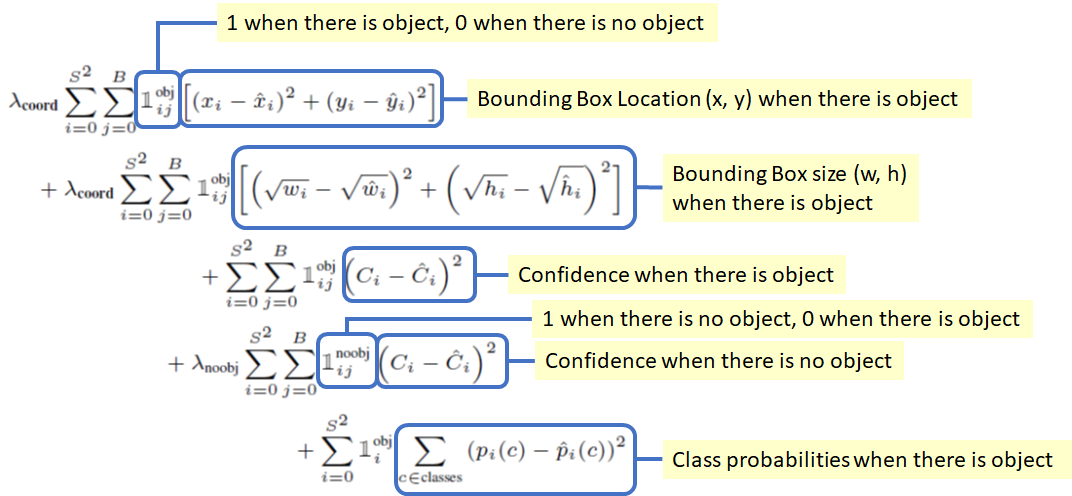

In [22]:
class YoloLoss(nn.Module):
    def __init__(self):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")
    
    def forward(self, output, target):
        output = output.reshape(-1, S, S, C + B * 5)

        classes_probabilities_output = output[..., 10:]
        classes_probabilities_target = target[..., 5:]

        # calculate iou for both boxes
        iou_box1 = IOU_tensor(output[..., 1:5], target[..., 1:5])
        iou_box2 = IOU_tensor(output[..., 6:10], target[..., 1:5])

        # filters to see which bounding box is better
        better_box1 = (iou_box1 >= iou_box2) * 1
        better_box2 = torch.abs(better_box1 - 1)

        # for each image get better box from cell, add dimension to better_box
        predicted_box = better_box1[..., None] * output[..., 1:5] + better_box2[..., None] * output[..., 6:10]
        confidence = better_box1[..., None] * output[..., 0:1] + better_box2[..., None] * output[..., 5:6]

        # I only penalize if object exists in the cell
        exists_object_filter = (target[..., 0:1] == 1) * 1
        not_exists_object_filter = torch.abs(exists_object_filter - 1)
        box_targets = exists_object_filter * target[..., 1:5]

        # ==========================
        # x, y, w, h part of loss
        # ==========================
        # derivative of sqrt(0) is going to be inifinity so we add SMOOTH
        # could be negative - use sign
        predicted_box = torch.sign(predicted_box) * torch.sqrt(
            torch.abs(predicted_box + SMOOTH)
        )
        box_targets = torch.sqrt(box_targets)


        # (N, S, S, 4) -> (N*S*S, 4) -> 1
        box_loss = LAMBDA_COORD * self.mse(
            torch.flatten(predicted_box, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2)
        )

        # (N*S*S, 4) -> (N*S*S)
        loss = box_loss
        print(loss.type())

        # ==========================
        # object loss (confidence)
        # ==========================
        # (N, S, S, 1) -> (N*S*S)
        object_loss = self.mse(
            torch.flatten(exists_object_filter * confidence),
            torch.flatten(exists_object_filter)
        )
        loss += object_loss

        # ==========================
        # no object loss (confidence)
        # ==========================

        no_object_loss = LAMBDA_NOOBJ * self.mse(
            torch.flatten(not_exists_object_filter * confidence),
            torch.flatten(not_exists_object_filter)
        )
        loss += no_object_loss

        # ==========================
        # class probabilities loss
        # ==========================
        # (N, S, S, 4) -> (N*S*S, 20)
        class_loss = self.mse(
            torch.flatten(exists_object_filter * classes_probabilities_output, end_dim=-2),
            torch.flatten(exists_object_filter * classes_probabilities_target, end_dim=-2)
        )

        loss += class_loss
        print(loss.type())

        return loss

### Training pipeline

In [31]:
# train the model
def train_model(train_dl, model):
    # define the optimization
    criterion = YoloLoss()
    optimizer = SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
    # enumerate epochs
    for epoch in range(EPOCHS):
        # enumerate mini batches
        # for i, (inputs, _, targets) in enumerate(train_dl):
            # clear the gradients
            # optimizer.zero_grad()
            # # compute the model output
            # yhat = model(inputs)
            # # calculate loss
            # loss = criterion(yhat, targets)
            # # credit assignment
            # loss.backward()
            # # update model weights
            # optimizer.step()
        inputs, targets = train_dl[0].to(torch.float32).to(device), train_dl[2].to(torch.float32).to(device)
        optimizer.zero_grad()
        # compute the model output
        yhat = model(inputs)
        # calculate loss
        loss = criterion(yhat, targets)
        # credit assignment
        loss.backward()
        # update model weights
        optimizer.step()

## Non-maximal suppression (TODO)

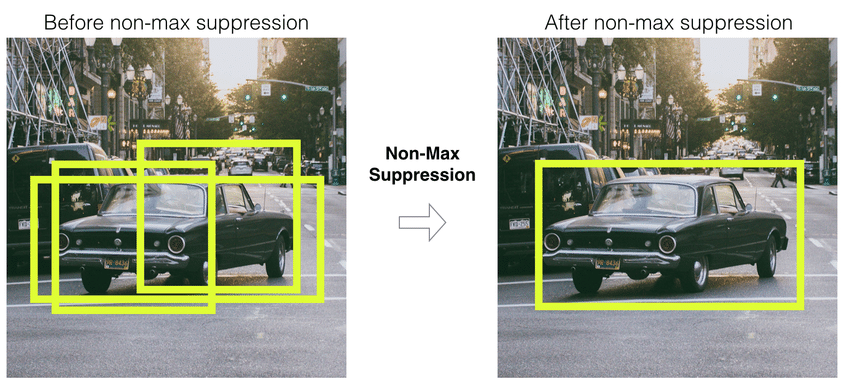

Source: https://www.researchgate.net/figure/Non-Maximal-Suppression_fig5_345061606

For large objects it's hard to tell in which cell they should be localized. Non-maximal suppression is used to fix multiple detecions of one object.

In [ ]:
def non_max_suppresion(test_dl, model):
  # TODO
    ...

## Evaluation (TODO)

In [ ]:
def evaluate_model():
    # TODO
    ...

### MAP

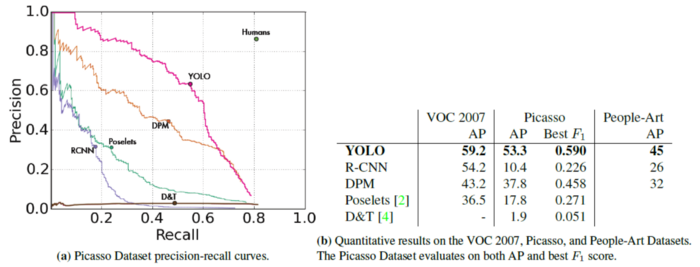

Source: YOLOv1 paper

In [ ]:
def mean_average_precision():
  # TODO
    ...

### Precision / recall curve

![image.png](attachment:b1ea9fe5-eea3-4b7e-a912-b82e06157c0a.png)

https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

In [ ]:
def precision_recall_curve():
    # TODO
    ...

## MAIN

In [24]:
def main():
    model = darknet()
    model.to(device)
    optimizer = SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
#     train_dl, test_dl = dataset.prepare_data()
    train_dl_main, test_dl_main = train_dl, test_dl
    one_batch = next(iter(train_dl))
    train_model(one_batch, model)
    # EVALUATION (TODO?)
    # map = evaluate_model(test_dl, model)

In [32]:
main()

torch.FloatTensor
torch.FloatTensor


RuntimeError: Found dtype Long but expected Float

In [33]:
!nvidia-smi

Thu Sep 30 14:26:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 470.63.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:0A:00.0  On |                  N/A |
| 50%   34C    P0    87W / 320W |   2102MiB / 10014MiB |     11%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [28]:
torch.cuda.empty_cache() 

In [ ]:
!nvidia-smi

In [ ]:
# tried:
#     float(), float()